In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import time
import pooch
import anndata as ad

In [2]:
EXAMPLE_DATA = pooch.create(
    path=pooch.os_cache("scverse_tutorials"),
    base_url="doi:10.6084/m9.figshare.22716739.v1/",
)
EXAMPLE_DATA.load_registry_from_doi()

In [3]:
path = EXAMPLE_DATA.fetch('s1d1_filtered_feature_bc_matrix.h5')
adata = sc.read_10x_h5(path)
adata.var_names_make_unique()

adata

/home/jasson/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/jasson/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 8785 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [4]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

raw_adata = adata.copy()

In [5]:
dat = pd.DataFrame(
    raw_adata.X.T.toarray() if not isinstance(raw_adata.X, np.ndarray) else raw_adata.X.T,
    index=adata.var_names,       # genes
    columns=adata.obs_names      # cells
)

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
sc.pp.scale(adata,max_value=10)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

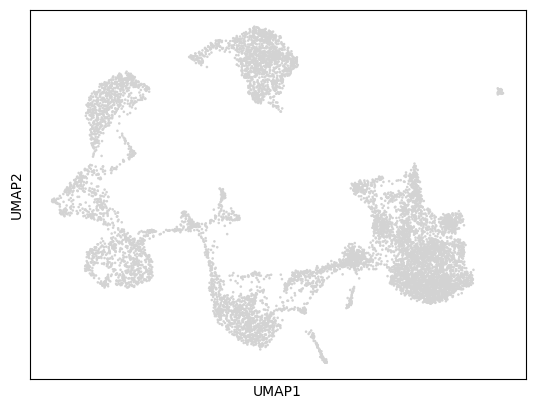

In [7]:
sc.pl.umap(adata)

In [8]:
cell_medians = np.median(dat, axis=0)
mask = dat > cell_medians

gene_detected_count = mask.sum(axis=1)

selected_genes = (gene_detected_count >= 10) & (gene_detected_count <= dat.shape[1] * 0.3)

adata = adata[:, selected_genes].copy()
raw_adata = raw_adata[:, selected_genes].copy()
dat = dat[selected_genes]

In [9]:
adata

AnnData object with n_obs × n_vars = 8713 × 16952
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [10]:
raw_adata

AnnData object with n_obs × n_vars = 8713 × 16952
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells'

In [11]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import connected_components
from scipy.spatial.distance import cdist
import networkx as nx
from typing import Tuple, List, Dict, Optional


def find_disconnected_components(A) -> Dict:
    """Find disconnected components in adjacency matrix."""

    if hasattr(A, 'tocsr'):
        A = A.tocsr()
    
    n_components, labels = connected_components(csgraph=A, directed=False, return_labels=True)
    
    components = []
    
    for i in range(n_components):
        component_indices = np.where(labels == i)[0]
        if len(component_indices) > 0:
            component = {idx: idx for idx in component_indices}
            components.append(component)
    
    return {'n_components': n_components, 'components': components}


def find_shortest_edge(comp1: Dict, comp2: Dict, feature_space: np.ndarray) -> Dict:
    """Find the shortest edge between two components."""
    indices1 = list(comp1.keys())
    indices2 = list(comp2.keys())
    
    # Calculate pairwise distances between components
    features1 = feature_space[indices1]
    features2 = feature_space[indices2]
    distances = cdist(features1, features2, metric='euclidean')
    
    # Find minimum distance
    min_idx = np.unravel_index(np.argmin(distances), distances.shape)
    
    return {
        'from': indices1[min_idx[0]],
        'to': indices2[min_idx[1]],
        'distance': distances[min_idx]
    }


def filter_sparse_matrix(A, row_indices, col_indices):
    """
    Properly filter a sparse matrix by row and column indices.
    """
    # Convert to COO format for easier manipulation
    A_coo = A.tocoo()
    
    # Create mapping from old indices to new indices
    row_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(row_indices)}
    col_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(col_indices)}
    
    # Filter and remap the COO data
    new_row = []
    new_col = []
    new_data = []
    
    for i, j, v in zip(A_coo.row, A_coo.col, A_coo.data):
        if i in row_mapping and j in col_mapping:
            new_row.append(row_mapping[i])
            new_col.append(col_mapping[j])
            new_data.append(v)
    
    # Create new sparse matrix with filtered data
    new_shape = (len(row_indices), len(col_indices))
    if len(new_data) > 0:
        filtered_A = coo_matrix((new_data, (new_row, new_col)), shape=new_shape)
    else:
        filtered_A = coo_matrix(new_shape)
    
    return filtered_A.tolil()


def construct_knn_graph(adata, 
                       knn: int = 5,
                       n_dim: Optional[int] = None,
                       adjust_disconnection: bool = True,
                       self_loop: int = 1) -> Dict:
    """
    Construct a k-nearest neighbor graph from AnnData PCA embeddings.
    
    """
    
    print("Constructing KNN graph")
    
    # Get feature space from PCA embeddings
    if 'X_pca' not in adata.obsm:
        raise ValueError("PCA embeddings not found in adata.obsm['X_pca']")
    
    if n_dim is None:
        feature_space = adata.obsm['X_pca'].copy()
    else:
        feature_space = adata.obsm['X_pca'][:, :n_dim].copy()
    
    # Ensure feature_space is a numpy array
    if hasattr(feature_space, 'toarray'):
        feature_space = feature_space.toarray()
    elif hasattr(feature_space, 'values'):  # pandas DataFrame
        feature_space = feature_space.values
    
    n_cells = feature_space.shape[0]
    cell_names = adata.obs_names.tolist()
    
    # Build kNN graph using sklearn
    nbrs = NearestNeighbors(n_neighbors=knn, algorithm='kd_tree')
    nbrs.fit(feature_space)
    distances, indices = nbrs.kneighbors(feature_space)
    
    # Create sparse adjacency matrix
    row_ind = np.repeat(np.arange(n_cells), knn)
    col_ind = indices.flatten()
    data = np.ones(len(row_ind))
    
    A = csr_matrix((data, (row_ind, col_ind)), shape=(n_cells, n_cells))
    A = A.tolil()  # Convert to lil_matrix for easier modification
    
    # Find disconnected components
    res = find_disconnected_components(A)
    
    # Filter components with at least 10 cells
    filtered_components = []
    for comp in res['components']:
        if len(comp) >= 10:
            filtered_components.append(comp)
    
    # Get indices of cells to keep
    filtered_node_indices = []
    for comp in filtered_components:
        filtered_node_indices.extend([int(idx) for idx in comp.keys()])  # Ensure integers
    filtered_node_indices = sorted(filtered_node_indices)
    
    # Filter adjacency matrix and feature space
    if len(filtered_node_indices) < n_cells:
        print(f"Remove {n_cells - len(filtered_node_indices)} singleton cells.")
        
        # Use custom filtering function for sparse matrix
        A = filter_sparse_matrix(A, filtered_node_indices, filtered_node_indices)
        feature_space_filtered = feature_space[filtered_node_indices]
        retained_cell_names = [cell_names[i] for i in filtered_node_indices]
        
        # Update component indices to match filtered matrix
        index_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(filtered_node_indices)}
        filtered_components_updated = []
        for comp in filtered_components:
            updated_comp = {}
            for old_idx in comp.keys():
                if old_idx in index_mapping:
                    updated_comp[index_mapping[old_idx]] = index_mapping[old_idx]
            if updated_comp:
                filtered_components_updated.append(updated_comp)
        filtered_components = filtered_components_updated
    else:
        feature_space_filtered = feature_space
        retained_cell_names = cell_names
    
    # Connect components using MST if requested
    if adjust_disconnection:
        while len(filtered_components) > 1:
            print(f"{len(filtered_components)} Disconnected Components, apply MST.")
            
            edges_to_add = []
            
            # Find shortest edges between all component pairs
            for i in range(len(filtered_components) - 1):
                for j in range(i + 1, len(filtered_components)):
                    edge = find_shortest_edge(
                        filtered_components[i], 
                        filtered_components[j], 
                        feature_space_filtered
                    )
                    edges_to_add.append(edge)
            
            # Create meta-graph of components
            edges_df = pd.DataFrame(edges_to_add)
            
            # Map edges to component indices
            comp_mapping = {}
            for comp_idx, comp in enumerate(filtered_components):
                for node_idx in comp.keys():
                    comp_mapping[node_idx] = comp_idx
            
            edges_df['comp_from'] = edges_df['from'].map(comp_mapping)
            edges_df['comp_to'] = edges_df['to'].map(comp_mapping)
            
            # Build graph and find MST
            G = nx.Graph()
            for _, row in edges_df.iterrows():
                if G.has_edge(row['comp_from'], row['comp_to']):
                    # Keep edge with minimum weight
                    if G[row['comp_from']][row['comp_to']]['weight'] > row['distance']:
                        G[row['comp_from']][row['comp_to']]['weight'] = row['distance']
                        G[row['comp_from']][row['comp_to']]['edge_data'] = row
                else:
                    G.add_edge(row['comp_from'], row['comp_to'], 
                              weight=row['distance'], edge_data=row)
            
            # Find minimum spanning tree
            mst = nx.minimum_spanning_tree(G, weight='weight')
            
            # Add MST edges to adjacency matrix
            edges_added = 0
            for edge in mst.edges():
                edge_data = G[edge[0]][edge[1]]['edge_data']
                from_idx = edge_data['from']
                to_idx = edge_data['to']
                A[from_idx, to_idx] = 1
                edges_added += 1
            
            print(f"add {edges_added} edges")
            
            # Recompute components
            res = find_disconnected_components(A)
            filtered_components = res['components']
    
    if len(filtered_components) >= 2:
        raise ValueError("Disconnected Components remain. Please increase knn or connect them.")
    
    # Convert to dense array for final processing
    A_dense = A.toarray()
    
    # Add self-loops
    np.fill_diagonal(A_dense, self_loop)
    
    # Symmetrize the adjacency matrix (unweighted version)
    W = np.minimum(A_dense + A_dense.T, 1)  # Unweighted graph
    np.fill_diagonal(W, self_loop)
    
    # Return sparse matrices if large
    if W.shape[1] > 10000:
        W = csr_matrix(W)
        A_final = csr_matrix(A_dense)
    else:
        A_final = A_dense
    
    return {
        'graph': W,
        'adj_matrix': A_final,
        'component': filtered_components,
        'cell_names': retained_cell_names
    }

In [12]:
result = construct_knn_graph(
    adata.copy(),
    knn=5,
    n_dim=20,
    adjust_disconnection=True,
    self_loop=1
)

W = result['graph']

Constructing KNN graph


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy.sparse as sp
from matplotlib.colors import ListedColormap

def visualize_graph_from_adata(
    affinity_m,
    adata,
    layout_key: str = "X_umap"
):
    """
    Plot a graph using:
      - affinity/adjacency matrix (sym, possibly sparse)
      - 2D visual space from adata.obsm[layout_key]
      
    """
    # --- matrix to dense for edge width calc
    A = affinity_m.toarray() if sp.issparse(affinity_m) else np.asarray(affinity_m)
    n = A.shape[0]

    if len(adata.obs_names) != n:
        raise ValueError(
            "nodes_obs_names not provided and adata.obs_names length "
            "does not match affinity matrix size."
        )
    idx = np.arange(n)
    obs_names_ordered = np.array(adata.obs_names)

    # --- get layout (2D)
    if layout_key not in adata.obsm:
        # helpful fallback suggestions
        candidates = [k for k in adata.obsm_keys() if k.lower().startswith("x_")]
        raise KeyError(
            f"'{layout_key}' not found in adata.obsm. "
            f"Available embeddings: {candidates or 'none'}"
        )
    layout_all = adata.obsm[layout_key]
    if layout_all.shape[1] < 2:
        raise ValueError(f"{layout_key} must have at least 2 dimensions (got {layout_all.shape[1]}).")
    layout = np.asarray(layout_all[idx, :2])  # align to nodes

    # --- build graph (ignore self-loops for drawing edges)
    G = nx.from_numpy_array(A)  # undirected
    self_loops = list(nx.selfloop_edges(G))
    G.remove_edges_from(self_loops)

    # --- positions dict for networkx
    pos = {i: (layout[i, 0], layout[i, 1]) for i in range(n)}

    # --- edge widths ~ weight (map to ~0.5–1 like the R plot)
    weights = np.array([G[u][v].get("weight", 1.0) for u, v in G.edges], dtype=float)
    if weights.size:
        w_min, w_max = weights.min(), weights.max()
        if w_max > w_min:
            widths = 0.5 + 0.5 * (weights - w_min) / (w_max - w_min)
        else:
            widths = np.full_like(weights, 0.75)
    else:
        widths = []

    node_colors = "black"
    legend_handles = None
    sm = None

    # --- draw
    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw_networkx_edges(G, pos, width=widths, edge_color="grey", alpha=0.7, ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=5, ax=ax)

    ax.set_axis_off()

    return fig, ax


In [14]:
unique, counts = np.unique(W[1], return_counts=True)

In [15]:
unique

array([0., 1.])

In [16]:
counts

array([8708,    5])

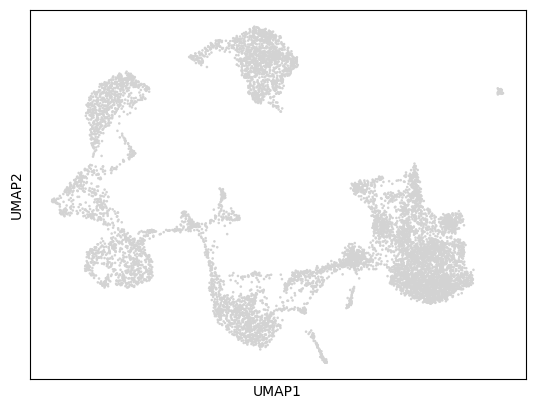

In [17]:
sc.pl.umap(adata)

(<Figure size 800x800 with 1 Axes>, <Axes: >)

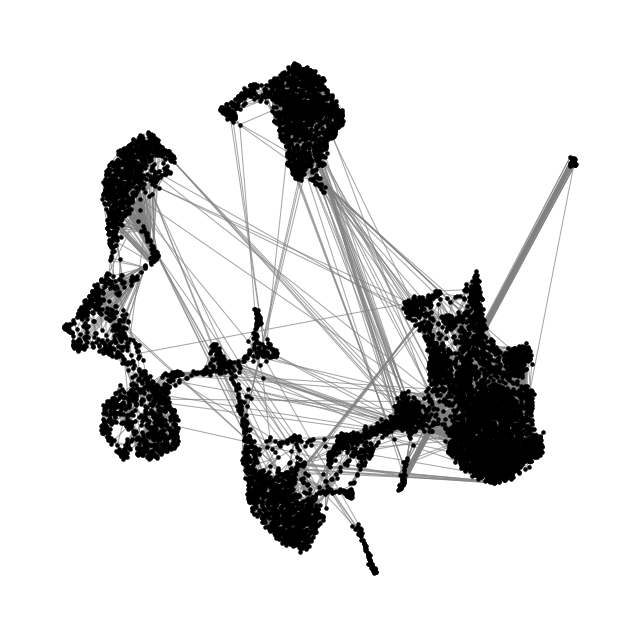

In [18]:
visualize_graph_from_adata(result['graph'], adata)

In [19]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

def rowwise_normalize(dat, W):
    """
    Row-normalize a genes x cells matrix, restricted to cells in W (matching column order).
    
    """
    # figure out cell order from W
    if isinstance(W, (np.ndarray, sp.spmatrix)):
        n = W.shape[0]
        cell_names = None
    else:
        raise ValueError("W must be numpy array or scipy sparse matrix.")

    if isinstance(dat, pd.DataFrame):
        # subset columns to match W column names
        if cell_names is None:
            # assume dat already restricted/ordered externally
            X = dat.values
            gene_names = dat.index
            cell_names = dat.columns
        else:
            X = dat.loc[:, cell_names].values
            gene_names = dat.index
    else:
        X = np.asarray(dat)
        gene_names = np.arange(X.shape[0])
        cell_names = np.arange(X.shape[1])

    # row sums
    row_sums = X.sum(axis=1)
    keep = row_sums != 0
    X = X[keep]
    row_sums = row_sums[keep][:, None]

    rho = X / row_sums

    return pd.DataFrame(rho, index=np.array(gene_names)[keep], columns=cell_names)


In [20]:
dat

,AAACCCAAGGATGGCT-1,AAACCCAAGGCCTAGA-1,AAACCCAAGTGAGTGC-1,AAACCCACAAGAGGCT-1,AAACCCACATCGTGGC-1,AAACCCACATTCTCTA-1,AAACCCAGTCCGCAGT-1,AAACCCAGTGCATACT-1,AAACCCAGTTGACGGA-1,AAACCCATCGATACTG-1,...,TTTGTTGAGCTTACGT-1,TTTGTTGAGGGATCGT-1,TTTGTTGAGGTTACCT-1,TTTGTTGAGTAGTCCT-1,TTTGTTGAGTCTAGAA-1,TTTGTTGCAAATCAGA-1,TTTGTTGCACGCCACA-1,TTTGTTGCATAGGAGC-1,TTTGTTGCATTCGATG-1,TTTGTTGGTCACTCAA-1
AL627309.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL627309.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01409,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC01128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
LINC00115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC240274.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC004556.3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AC233755.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
rho = rowwise_normalize(dat, W)

In [22]:
rho

,AAACCCAAGGATGGCT-1,AAACCCAAGGCCTAGA-1,AAACCCAAGTGAGTGC-1,AAACCCACAAGAGGCT-1,AAACCCACATCGTGGC-1,AAACCCACATTCTCTA-1,AAACCCAGTCCGCAGT-1,AAACCCAGTGCATACT-1,AAACCCAGTTGACGGA-1,AAACCCATCGATACTG-1,...,TTTGTTGAGCTTACGT-1,TTTGTTGAGGGATCGT-1,TTTGTTGAGGTTACCT-1,TTTGTTGAGTAGTCCT-1,TTTGTTGAGTCTAGAA-1,TTTGTTGCAAATCAGA-1,TTTGTTGCACGCCACA-1,TTTGTTGCATAGGAGC-1,TTTGTTGCATTCGATG-1,TTTGTTGGTCACTCAA-1
AL627309.1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AL627309.5,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
LINC01409,0.0,0.000000,0.0,0.002079,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
LINC01128,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000841,0.0,0.0,0.0
LINC00115,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AL592183.1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.001642,...,0.0,0.001642,0.001642,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AC240274.1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AC004556.3,0.0,0.000922,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000922,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
AC233755.1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [23]:
import numpy as np
from scipy import sparse
from typing import Dict, Union
import warnings

def doubly_stochastic(W: np.ndarray, max_iter: int = 100, tol: float = 1e-6) -> np.ndarray:
    """
    Convert a symmetric affinity matrix to a doubly stochastic matrix using the Sinkhorn-Knopp algorithm.
    
    """
    n = W.shape[0]
    P = W.copy()
    
    for _ in range(max_iter):
        # Row normalization
        row_sums = P.sum(axis=1, keepdims=True)
        row_sums[row_sums == 0] = 1  # Avoid division by zero
        P = P / row_sums
        
        # Column normalization
        col_sums = P.sum(axis=0, keepdims=True)
        col_sums[col_sums == 0] = 1  # Avoid division by zero
        P = P / col_sums
        
        # Check convergence
        if np.allclose(P.sum(axis=1), 1, atol=tol) and np.allclose(P.sum(axis=0), 1, atol=tol):
            break
    
    return P


def rowwise_normalize(W: np.ndarray) -> np.ndarray:
    """
    Row-wise normalization of a matrix (creates a row-stochastic matrix).
    
    """
    row_sums = W.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    return W / row_sums


def construct_diffusion_operators(
    W: Union[np.ndarray, sparse.spmatrix], 
    max_time: int,
) -> Dict[int, sparse.spmatrix]:
    """
    Constructs a list of diffusion operators for a given symmetric affinity matrix of a graph.
    
    """
    
    print("Creating diffusion operators...")
    
    # Convert to dense array if sparse for initial processing
    if sparse.issparse(W):
        W_dense = W.toarray()
    else:
        W_dense = W.copy()
    
    P = doubly_stochastic(W_dense)
    
    n = P.shape[0]
    
    if max_time < 1:
        raise ValueError("Incorrect diffusion time, no propagation (max_time must be >= 1)")
    
    # Initialize list with identity matrix (t=0)
    P_dict = {0: sparse.identity(n, format='csr')}
    
    # Current P matrix
    P_current = P.copy()
    t = 1
    max_steps = int(np.floor(np.log2(max_time)))
    
    # Convergence criterion: check if diagonal approaches n
    convergence_threshold = n
    
    while t <= max_steps:
        # Check convergence: if diagonal elements approach uniform distribution
        diag_check = np.abs((n * np.diag(P_current)) * n - n)
        max_deviation = np.max(diag_check)
        
        print(f"Step {t}: max deviation from convergence = {max_deviation:.6f}")
        
        if max_deviation < convergence_threshold:
            print(f"Converged at step {t} (time = {2**(t-1)})")
            break
        
        # Compute P^(2^t) = P^(2^(t-1)) * P^(2^(t-1))
        P_current = P_current @ P_current
        
        # Store as sparse matrix
        P_dict[2**t] = sparse.csr_matrix(P_current)
        
        t += 1
    
    actual_max_time = 2**(t-1) if t > 1 else 0
    print(f"Max diffusion time: {actual_max_time}")
    print(f"Total operators created: {len(P_dict)}")
    
    return P_dict

In [24]:
test_P = doubly_stochastic(W.copy())

In [25]:
test_P

array([[0.09448852, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.2403082 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.13372221, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.18775713, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.36596881,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.26071296]])

In [26]:
np.sum(test_P < 0)

0

In [27]:
np.sum(test_P > 0)

62679

In [28]:
start_time = time.time()
P_ls = construct_diffusion_operators(W, max_time=2**15)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Creating diffusion operators...
Step 1: max deviation from convergence = 39390753.894464
Step 2: max deviation from convergence = 24941264.614857
Step 3: max deviation from convergence = 13009810.440578
Step 4: max deviation from convergence = 10028434.252970
Step 5: max deviation from convergence = 6840649.481118
Step 6: max deviation from convergence = 4420070.561928
Step 7: max deviation from convergence = 2713545.360439
Step 8: max deviation from convergence = 1540913.531390
Step 9: max deviation from convergence = 749709.352234
Step 10: max deviation from convergence = 409505.756063
Step 11: max deviation from convergence = 126057.876253
Step 12: max deviation from convergence = 21675.661522
Step 13: max deviation from convergence = 4527.161908
Converged at step 13 (time = 4096)
Max diffusion time: 4096
Total operators created: 13
Execution time: 120.58168077468872 seconds


In [29]:
P_ls

{0: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 8713 stored elements in Compressed Sparse Row format>,
 2: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 278163 stored elements in Compressed Sparse Row format>,
 4: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 2276529 stored elements in Compressed Sparse Row format>,
 8: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 15468025 stored elements in Compressed Sparse Row format>,
 16: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 69486045 stored elements in Compressed Sparse Row format>,
 32: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 75916369 stored elements in Compressed Sparse Row format>,
 64: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 75916369 stored elements in Compressed Sparse Row format>,
 128: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 75916369 stored elements in C

In [30]:
print(P_ls[2])

  (0, 0)	0.12144573607359917
  (0, 139)	0.00840439661145017
  (0, 142)	0.0020768337755650663
  (0, 448)	0.032983139575370905
  (0, 625)	0.022051307030394873
  (0, 783)	0.004460391513802318
  (0, 825)	0.026084953763035577
  (0, 1020)	0.01088078315694705
  (0, 1488)	0.05128617426334771
  (0, 1678)	0.012359366675085522
  (0, 1722)	0.025388013474281164
  (0, 1859)	0.01291719413834938
  (0, 2166)	0.027667752039884006
  (0, 2250)	0.006510551347221092
  (0, 2548)	0.005392558523107441
  (0, 2788)	0.0066994608223400805
  (0, 2870)	0.0397966072838232
  (0, 2927)	0.008533681530788227
  (0, 3383)	0.05115066137368627
  (0, 3408)	0.0031379909813585996
  (0, 3603)	0.00855322413814739
  (0, 3762)	0.03305172608577512
  (0, 3788)	0.022568121815734154
  (0, 3895)	0.0200507601483382
  (0, 4031)	0.004074677080875067
  :	:
  (8711, 6444)	0.05045779839642224
  (8711, 6717)	0.030693128935321553
  (8711, 7057)	0.035725080673848206
  (8711, 7507)	0.008039886773595753
  (8711, 7526)	0.009657568851983718
  (8711,

In [31]:
print(P_ls[4][(0,0)])

0.042360852800602346


In [32]:
list(P_ls.keys())

[0, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]

In [34]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgba

def visualize_diffusion(
    coord,
    rho,
    gene_name,
    P_ls=None,
    W=None,
    gene_color="blue",
    construct_diffusion_fn=None,   # pass construct_diffusion_operators if you want auto-build from W
    figsize_per_panel=(4, 4),
    point_size=8,
):
    """
    Visualize diffusion of an initial state over dyadic times.
    """
    # --- inputs to arrays ---
    coord = np.asarray(coord)
    N = coord.shape[0]

    init = np.asarray(rho.loc[gene, adata.obs_names].values)
    # Make it a (1, N) row vector
    if init.ndim == 1:
        init = init[None, :]
    if init.shape[0] != 1 and init.shape[1] == 1:
        init = init.T

    # --- ensure P_ls available ---
    if P_ls is None:
        raise ValueError("Provide P_ls.")
        
    times = np.quantile(list(P_ls.keys()), [0, 0.25, 0.5, 0.75, 1])

    # P_ls may have keys as ints; make a view with int keys
    P_map = {}
    for k, v in P_ls.items():
        try:
            key = int(k)
        except Exception:
            # if keys are strings like "0","2","4", try to parse
            key = int(str(k))
        P_map[key] = v

    # keep only times present
    times = [t for t in times if t in P_map]
    if not times:
        raise ValueError("None of the requested check_time values are present in P_ls.")

    # --- compute multi_state for each time ---
    # multi_state will be (N, len(times)) (we’ll transpose after computing rowwise)
    states = []
    max_vals = []
    for t in times:
        P = P_map[t]
        P = P if sp.issparse(P) else np.asarray(P)
        # init is (1,N); want (N, ) result transposed to (N,)
        state = (init @ P).ravel()
        states.append(state)
        max_vals.append(np.max(state) if state.size else 0.0)

    multi_state = np.column_stack(states)  # shape (N, T)
    # normalize each column to [0,1]
    col_max = np.array(max_vals)
    multi_state_norm = multi_state / col_max

    # --- color map from lightgrey -> gene_color ---
    high_rgba = to_rgba(gene_color)
    cmap = LinearSegmentedColormap.from_list("gene_grad", ["lightgrey", high_rgba])

    # --- plot panels in one row ---
    n_panels = len(times)
    fig_w = figsize_per_panel[0] * n_panels
    fig_h = figsize_per_panel[1]
    fig, axes = plt.subplots(1, n_panels, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes[0]

    # helper to build title like R: T=0 or T=2^{k}
    def _panel_title(t):
        if t == 0:
            return r"$T = 0$"
        k = int(np.log2(t))
        return rf"$T = 2^{{{k}}}$"

    for j, ax in enumerate(axes):
        vals = multi_state_norm[:, j]
        # order points so high values on top
        order = np.argsort(vals)
        x = coord[order, 0]
        y = coord[order, 1]
        c = vals[order]
        
        sc = ax.scatter(x, y, c=c, s=point_size, cmap=cmap, vmin=0.0, vmax=1.0, linewidths=0)
        ax.set_title(_panel_title(times[j]), fontsize=14, fontweight="bold")
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_frame_on(False)
        
        cb = plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04)
        cb.set_label("Density", fontsize=10)
        cb.set_ticks([0.0, 1.0])

    if gene_name:
        fig.suptitle(gene_name, fontsize=18, fontweight="bold", y=0.98)

    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig, axes

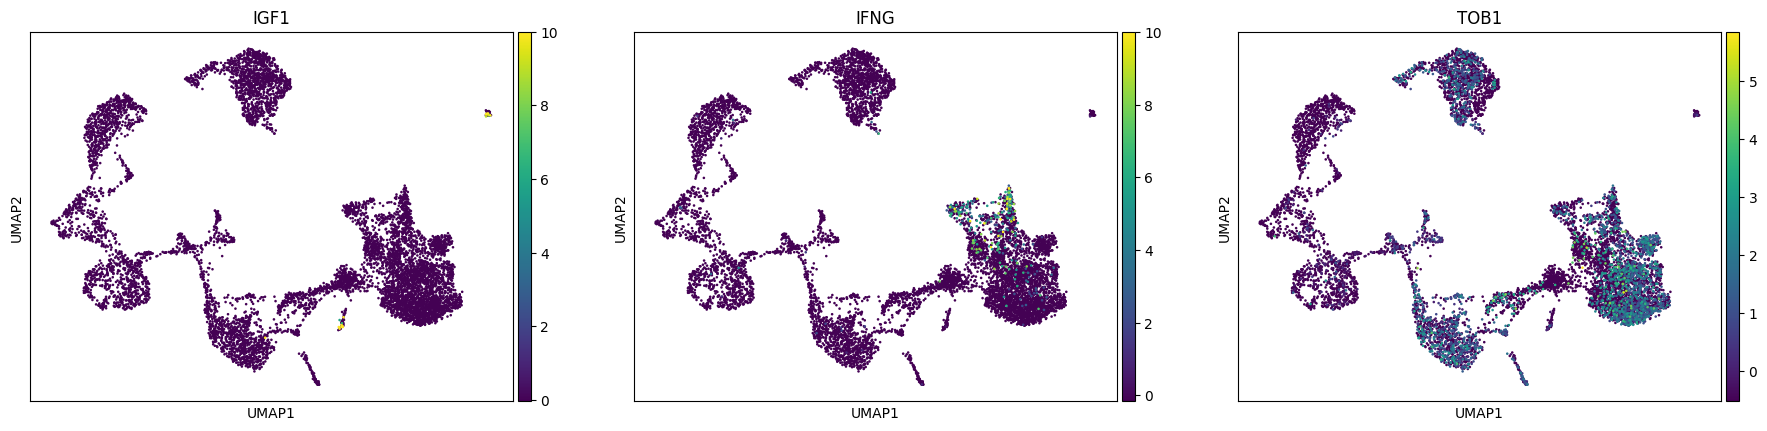

In [35]:
sc.pl.umap(adata, color = ['IGF1','IFNG','TOB1'])

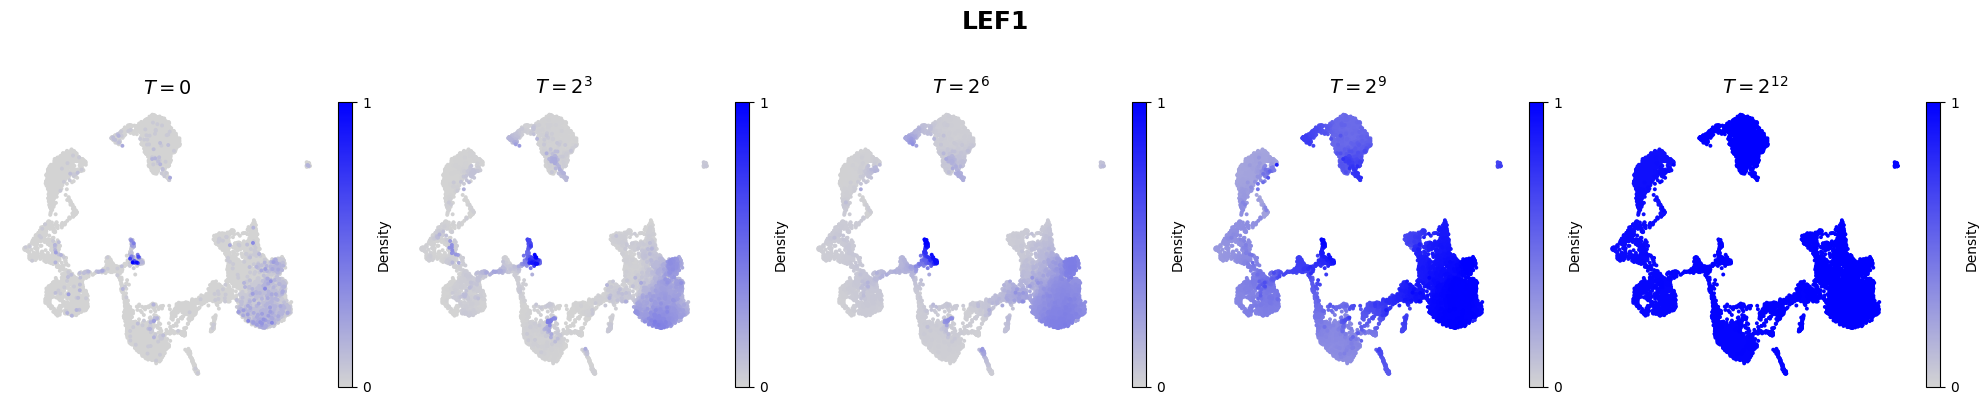

In [36]:
gene = 'LEF1'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    gene_name=gene,
    gene_color="blue"
)

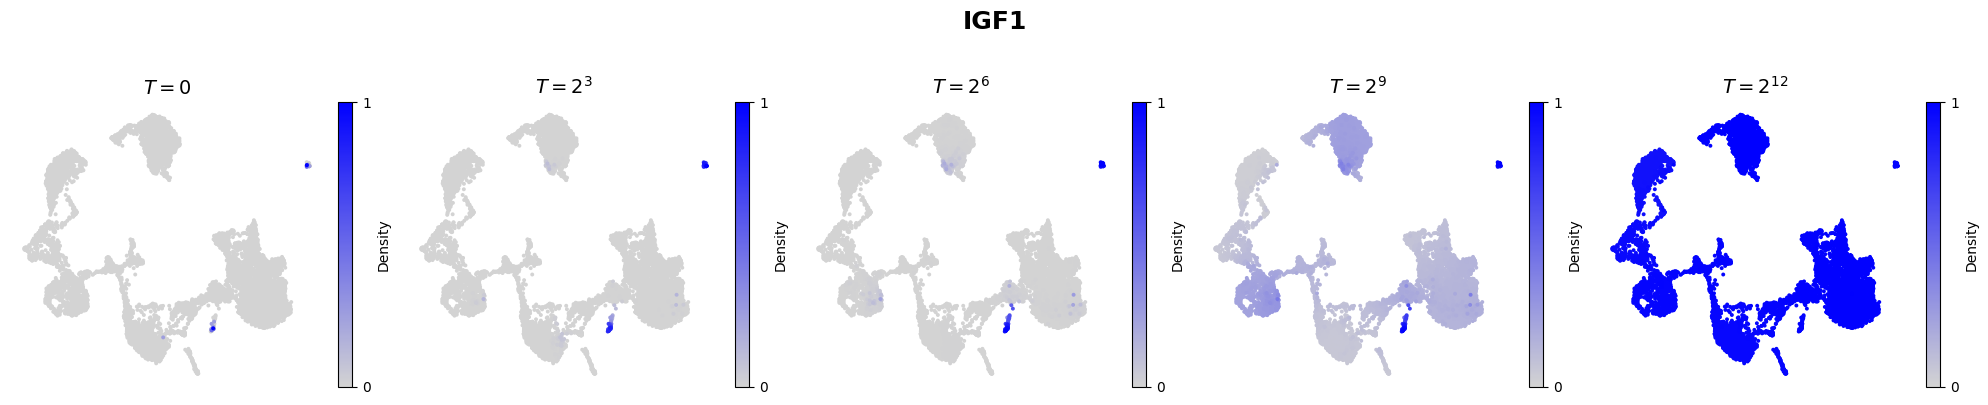

In [37]:
gene = 'IGF1'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    gene_name=gene,
    gene_color="blue"
)

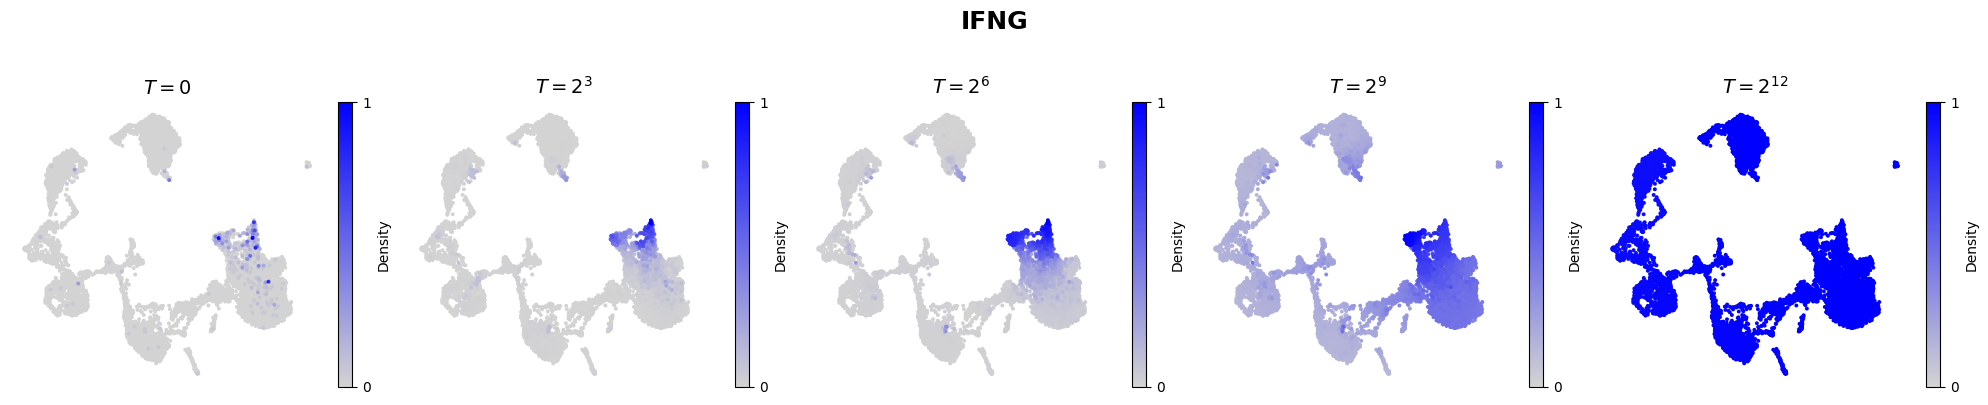

In [38]:
gene = 'IFNG'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    gene_name=gene,
    gene_color="blue"
)

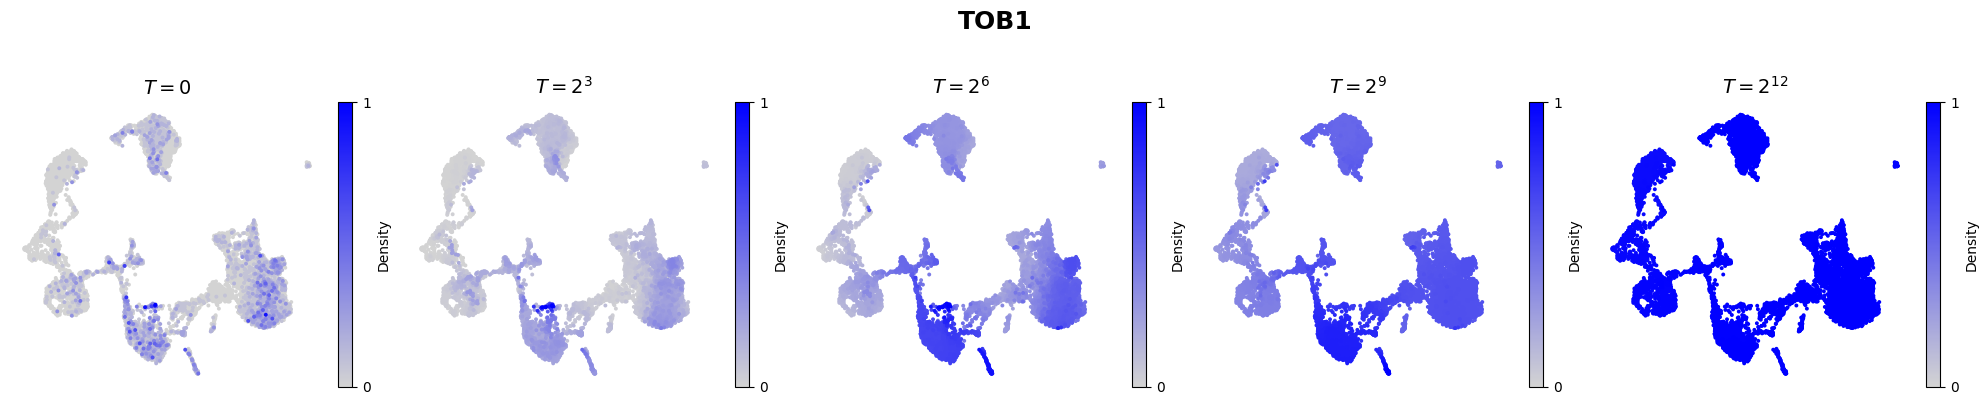

In [39]:
gene = 'TOB1'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    gene_name=gene,
    gene_color="blue"
)

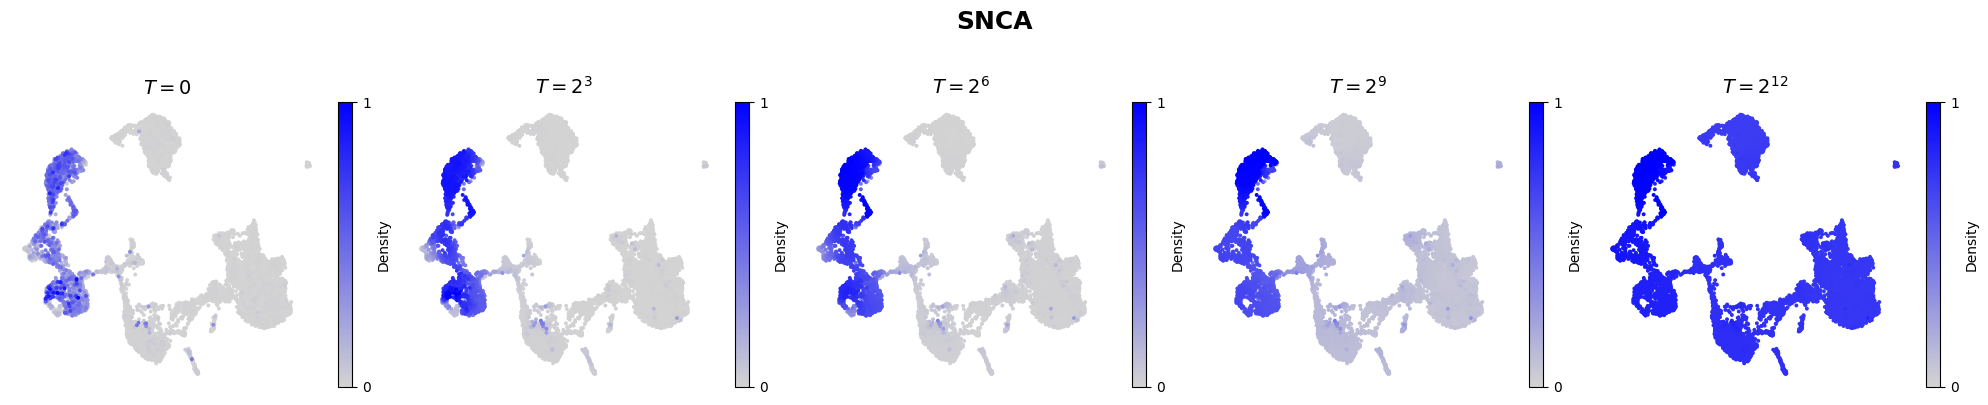

In [40]:
gene = 'SNCA'
fig, axes = visualize_diffusion(
    coord=adata.obsm['X_umap'],
    rho=rho,
    P_ls=P_ls,
    gene_name=gene,
    gene_color="blue"
)

In [41]:
P_ls

{0: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 8713 stored elements in Compressed Sparse Row format>,
 2: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 278163 stored elements in Compressed Sparse Row format>,
 4: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 2276529 stored elements in Compressed Sparse Row format>,
 8: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 15468025 stored elements in Compressed Sparse Row format>,
 16: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 69486045 stored elements in Compressed Sparse Row format>,
 32: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 75916369 stored elements in Compressed Sparse Row format>,
 64: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 75916369 stored elements in Compressed Sparse Row format>,
 128: <8713x8713 sparse matrix of type '<class 'numpy.float64'>'
 	with 75916369 stored elements in C

In [42]:
from __future__ import annotations
from collections import OrderedDict
from typing import Iterable, Dict, Tuple, Union
import numpy as np
import pandas as pd
import scipy.sparse as sp
import cupy as cp


# ---------- helpers ----------
def _as_dense(a):
    return a.toarray() if sp.issparse(a) else np.asarray(a)

def fast_matmul(A, B):
    if sp.issparse(A) and sp.issparse(B):
        return (A @ B).toarray()  # genes x cells, dense result
    elif sp.issparse(A):
        return (A @ B)  # dense or sparse B → dense np.ndarray if B dense
    elif sp.issparse(B):
        return A @ B     # returns np.ndarray
    else:
        return A @ B

def _rowwise_kl(p: np.ndarray, q: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """
    KL divergence per row: KL(p || q) = sum_i p_i * log(p_i / q_i)
    Assumes rows sum to ~1. Adds eps for numerical stability.
    Returns 1D array of length n_rows.
    """
    p = np.clip(p, eps, 1.0)
    q = np.clip(q, eps, 1.0)
    return np.sum(p * (np.log(p) - np.log(q)), axis=1)

def _rowwise_entropy(p: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """Shannon entropy per row: H(p) = -sum_i p_i log p_i."""
    p = np.clip(p, eps, 1.0)
    return -np.sum(p * np.log(p), axis=1)

def get_score_profile(
    state_inf: np.ndarray,      # (cells,) stationary distribution
    state_t: np.ndarray,
) -> pd.DataFrame:
    """
    Compute requested score columns. Supported keys:
      - 'score0'   : KL(state_t || state_inf)
      - 'entropy'  : entropy(state_0)
      - 'max_score0': KL(state_0 || state_inf)  (used as normalizer baseline)
    Returns DataFrame with rows = genes, cols = requested metrics.
    """
    # ensure arrays
    ST = np.asarray(state_t)
    pi = np.asarray(state_inf).ravel()
    
    if ST.shape[1] != pi.shape[0]:
        raise ValueError("state_inf length must equal #cells.")

    n_genes = ST.shape[0]
    out = {}

    # broadcast pi to row shape when needed
    pi_row = np.broadcast_to(pi, ST.shape)
    
    out["score0"] = _rowwise_kl(ST, pi_row)
    
    return pd.DataFrame(out, index=np.arange(n_genes))


# ---------- main function ----------
def fast_calculate_score_profile(
    W,
    init_state,
    score_ls,
    P_ls
) -> pd.DataFrame:
    
    Wn = W.shape[0]

    gene_names = init_state.index.copy()
    X = init_state.values
    
    if Wn != X.shape[1] and Wn == X.shape[0]:
        X = X.T

    if Wn != X.shape[1]:
        raise ValueError("Check the dimension! init_state must have #cells equal to W.shape[0].")

    final_state = np.full(Wn, 1.0 / Wn, dtype=float)

    # ----- compute per-time scores and cbind -----
    per_time_frames = []
    for P in P_ls:
        if P_ls[P].nnz < 1000000:
            df_t = get_score_profile(
                state_t=(X @ P_ls[P]),
                state_inf=final_state,
            )
        else:
            df_t = get_score_profile(
                state_t=cp.asnumpy(cp.asarray(X) @ cp.asarray(_as_dense(P_ls[P]))),
                state_inf=final_state,
            )

        df_t.columns = [f"{col}_{P}" for col in df_t.columns]
        per_time_frames.append(df_t)

    score_df = pd.concat(per_time_frames, axis=1)
    
    #pi_row = np.broadcast_to(final_state, X.shape)
    #max_score0 = _rowwise_kl(X, pi_row)
    #score_df = pd.concat(max_score0, axis=1)
    
    score_df.index = gene_names

    return score_df

In [43]:
X = rho.values

In [44]:
start_time = time.time()
print(X @ P_ls[0])
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00092166 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Execution time: 3.4536051750183105 seconds


In [45]:
for P in P_ls:
    print(P_ls[P].nnz)

8713
278163
2276529
15468025
69486045
75916369
75916369
75916369
75916369
75916369
75916369
75916369
75916369


In [46]:
start_time = time.time()
print(X @ P_ls[2])
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.59456133e-05 9.13521168e-05 0.00000000e+00 ... 1.23715260e-04
  1.25072315e-04 4.76784472e-05]
 ...
 [1.27513956e-04 4.88810603e-04 0.00000000e+00 ... 6.72692664e-05
  7.12432713e-05 2.39926032e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
Execution time: 5.546175718307495 seconds


In [ ]:
start_time = time.time()
score_df = fast_calculate_score_profile(
    W = W,
    init_state = rho,
    score_ls = ("score0",),
    P_ls = P_ls
)
end_time = time.time()
execution_time = end_time - start_time
print(f"2**15 GPU Accelerated Execution time: {execution_time} seconds")

In [ ]:
score_df

In [ ]:
time_step = 0

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(_as_dense(P_ls[time_step]))
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

In [ ]:
time_step = 2

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(_as_dense(P_ls[time_step]))
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

In [ ]:
time_step = 4

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(_as_dense(P_ls[time_step]))
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

In [ ]:
time_step = 8

start_time = time.time()
print(X @ P_ls[time_step])
end_time = time.time()
execution_time = end_time - start_time
print(f"CPU time: {execution_time} seconds")

start_time = time.time()
cp_rho = cp.asarray(X)
cp_P_ls = cp.asarray(_as_dense(P_ls[time_step]))
print(cp_rho @ cp_P_ls)
end_time = time.time()
execution_time = end_time - start_time
print(f"GPU time: {execution_time} seconds")

In [ ]:
import numpy as np
import pandas as pd

def obtain_lmds(score_profile: pd.DataFrame) -> pd.Series:
    """
    Compute LMDS (cumulative normalized diffusion KL score).
    """

    cols = score_profile.columns.astype(str)
    score0_cols = [c for c in cols if c.startswith("score0")]
    
    denom = score_profile["score0_0"].replace(0, np.nan)
    df_norm = score_profile.div(denom, axis=0)
    cumulative_score = df_norm[score0_cols].sum(axis=1)

    # Replace NaNs (from 0 denominators) with 0 to mimic R's permissive behavior
    cumulative_score = cumulative_score.fillna(0.0)
    cumulative_score.name = "LMDS"
    
    return cumulative_score

In [ ]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_score_pattern(
    score_profile: pd.DataFrame,
    genes=None,
    label_class=None,
    facet_class=None,
    add_point=None, 
    dyadic: bool = True,
    text: bool = False,
    normalize: bool = False,
    figsize=(10, 4),
):
    if genes is None:
        raise ValueError("`genes` must be provided.")

    # Validate genes
    score_df = score_profile.copy()
    genes = list(genes)
    missing = [g for g in genes if g not in score_df.index]
    if missing:
        raise ValueError(f"Genes not found: {missing[:5]}{'...' if len(missing) > 5 else ''}")

    # Subset to genes of interest
    score_df = score_df.loc[genes].copy()

    # Determine score columns that look like "<profile>_<time>"
    # Keep also potential helper column 'max_score0' (used for normalization) and any other non-matching columns as id vars.
    score_cols = []
    id_like_cols = []
    pat = re.compile(r"^(.*)_(\d+)$")  # profile, time
    for c in score_df.columns:
        m = pat.match(c)
        if m:
            score_cols.append(c)
        else:
            id_like_cols.append(c)

    # What profiles do we have? A "profile" is the part before the last "_" where the remainder is a number
    profiles = []
    for c in score_cols:
        m = pat.match(c)
        if m:
            profiles.append(m.group(1))
    profiles = pd.Series(profiles)
    prof_counts = profiles.value_counts()
    multi_prof = list(prof_counts[prof_counts > 1].index)  # matches R logic for >1 occurrences

    # Optional normalization if "score0" among profiles (R checks profiles for 'score0' and divides by 'max_score0')
    if normalize and ("score0" in set(multi_prof)):
        if "max_score0" not in score_df.columns:
            raise ValueError("normalize=True but 'max_score0' column not found in score_profile.")
        score_df.loc[:, score_cols] = score_df.loc[:, score_cols].div(score_df["max_score0"], axis=0)

    # Add helper columns like in R
    score_df["gene"] = score_df.index
    # label: either supplied class or default to gene name
    if label_class is not None and len(label_class) == len(genes):
        score_df["label"] = list(label_class)
    else:
        if label_class is not None and len(label_class) != len(genes):
            print("Warning: Labels don't match genes length; ignoring labels.")
        score_df["label"] = score_df["gene"]

    # facet column
    score_df["facet"] = np.nan
    if facet_class is not None:
        if isinstance(facet_class, str) and facet_class == "profiles":
            pass  # will facet on 'profiles' after melting
        elif hasattr(facet_class, "__len__") and len(facet_class) == len(genes):
            score_df["facet"] = list(facet_class)
        else:
            print("Warning: Facet labels don't match genes; ignoring facet labels.")

    # Melt to long format
    id_vars = [c for c in score_df.columns if c not in score_cols]
    df = score_df.melt(id_vars=id_vars, value_vars=score_cols,
                       var_name="step_raw", value_name="score")

    # Parse profile and numeric time from step_raw
    def parse_step(s):
        m = pat.match(s)
        if not m:
            return None, None
        prof = m.group(1)
        step = int(m.group(2))
        return prof, step

    parsed = df["step_raw"].apply(parse_step)
    df["profiles"] = [p[0] for p in parsed]
    df["step"] = [p[1] for p in parsed]

    # Build x breaks and decide dyadic relabeling
    x_breaks = np.unique(df["step"].dropna().astype(int))
    x_breaks = np.sort(x_breaks)
    if x_breaks.size >= 2:
        gaps = np.diff(x_breaks)
    else:
        gaps = np.array([0])

    # If dyadic requested and gaps > 1 exist, relabel steps to 2^k form
    label_map = None
    use_category_x = False
    if dyadic and (gaps.max() > 1):
        # Map numeric time t -> '2^k' where k=log2(t); special-case t==0
        def dy_label(t):
            if t == 0:
                return "0"
            k = np.log2(t)
            if np.isneginf(k):
                return "0"
            # show as 2^k (integer if close)
            k_int = int(round(k))
            return f"2^{k_int}"
        label_map = {int(t): dy_label(int(t)) for t in x_breaks}
        df["step_lab"] = df["step"].map(label_map)
        # Make categorical ordered by x_breaks
        cat_order = [label_map[int(t)] for t in x_breaks]
        df["step_cat"] = pd.Categorical(df["step_lab"], categories=cat_order, ordered=True)
        use_category_x = True
    else:
        df["step_cat"] = df["step"]  # numeric axis

    # Build the plot
    # Color by label if provided; else by gene. Style by profiles.
    hue_key = "label" if label_class is not None and len(label_class) == len(genes) else "gene"
    style_key = "profiles"

    # Prepare figure / FacetGrid
    if facet_class == "profiles":
        g = sns.relplot(
            data=df, x="step_cat", y="score",
            hue=hue_key, style=style_key, kind="line",
            col="profiles", col_wrap=None, facet_kws=dict(sharey=False, sharex=True),
            height=figsize[1], aspect=figsize[0] / figsize[1] / max(1, df["profiles"].nunique()),
            estimator=None, units="gene",  # draw each gene-profile line
            lw=1.5
        )
        axes = g.axes.flatten()
        fig = g.fig
    elif "facet" in score_df.columns and score_df["facet"].notna().any():
        g = sns.relplot(
            data=df, x="step_cat", y="score",
            hue=hue_key, style=style_key, kind="line",
            col="facet", col_wrap=None, facet_kws=dict(sharey=False, sharex=True),
            height=figsize[1], aspect=figsize[0] / figsize[1] / max(1, df["facet"].nunique()),
            estimator=None, units="gene",
            lw=1.5
        )
        axes = g.axes.flatten()
        fig = g.fig
    else:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
        sns.lineplot(
            data=df, x="step_cat", y="score",
            hue=hue_key, style=style_key,
            estimator=None, units="gene",
            lw=1.5, ax=ax
        )

    # Optional point highlights at specific times
    if add_point is not None and len(add_point) > 0:
        # Map numeric times to the x labels in use
        if use_category_x:
            # convert to labels via label_map, then plot points where step_cat matches
            wanted = [label_map.get(int(t)) for t in add_point if int(t) in label_map]
            df_pts = df[df["step_cat"].isin(wanted)]
        else:
            df_pts = df[df["step_cat"].isin(add_point)]
        for ax in axes:
            sns.scatterplot(data=df_pts, x="step_cat", y="score", hue=hue_key,
                            s=30, edgecolor="none", ax=ax, legend=False)
            # Emulate R axis tick styling (bold/red for highlighted)
            if use_category_x:
                xticks = ax.get_xticks()
                xticklabels = [t.get_text() for t in ax.get_xticklabels()]
                new_colors, new_fonts = [], []
                for lab in xticklabels:
                    if lab in set(df_pts["step_cat"].unique()):
                        new_colors.append("red")
                        new_fonts.append("bold")
                    else:
                        new_colors.append("black")
                        new_fonts.append("normal")
                for lbl, c, f in zip(ax.get_xticklabels(), new_colors, new_fonts):
                    lbl.set_color(c)
                    lbl.set_fontweight(f)

    # Optional tail labels
    if text:
        # For each (gene, profiles) curve, annotate last point
        # We’ll take the max step per (gene,profiles) present in df
        last_pts = (
            df.dropna(subset=["step"])
              .sort_values("step")
              .groupby(["gene", "profiles"], as_index=False)
              .tail(1)
        )
        for ax in axes:
            # If using categorical axis, x is label; else numeric
            xs = last_pts["step_cat"].values
            ys = last_pts["score"].values
            labels = last_pts["gene"].values
            for x, y, lab in zip(xs, ys, labels):
                ax.text(x, y, str(lab), ha="left", va="center", fontsize=8)

    # Common styling (titles, labels)
    for ax in axes:
        ax.set_xlabel("Time", fontsize=14)
        ax.set_ylabel("Normalized Diffusion KL Score", fontsize=14)
        if use_category_x:
            for tick in ax.get_xticklabels():
                tick.set_rotation(45)
                tick.set_ha("right")

    # Title sizing (global)
    if isinstance(axes[0], plt.Axes):
        fig.suptitle("", fontsize=16, fontweight="bold")  # placeholder if you want a global title

    # Legend styling
    # (seaborn handles legend; you can tweak sizes below)
    for ax in axes:
        leg = ax.get_legend()
        if leg is not None:
            leg.set_title(leg.get_title().get_text())  # keep existing
            for txt in leg.get_texts():
                txt.set_fontsize(10)

    fig.tight_layout()
    return fig, (g if 'g' in locals() else axes[0])

In [ ]:
score_profile = obtain_lmds(score_df)

In [ ]:
score_df

In [ ]:
visualize_score_pattern(pd.DataFrame(score_df), genes = ['IGF1', 'TOB1'])

In [ ]:
visualize_score_pattern(pd.DataFrame(score_df), genes = ['COL26A1', 'KAT6A','LEF1', 'IGF1'])

In [ ]:
visualize_score_pattern(pd.DataFrame(score_df), genes = ['TPSAB1', 'KAT6A', 'SNCA', 'GPM6A'])

In [ ]:
sc.pl.umap(adata, color = ['TPSAB1', 'KAT6A'])

In [ ]:
sort_score = pd.DataFrame(score_profile).sort_values(by='LMDS')

In [ ]:
top = sort_score[:10]
bot = sort_score[int(len(sort_score)-10):]

In [ ]:
sc.pl.umap(adata, color = list(top.index))

In [ ]:
sc.pl.umap(adata, color = list(bot.index))

In [ ]:
plt.plot(sorted(score_profile[::500]))